### Mixed ANOVA

Based on [McDermott et al (2016)](https://www.nature.com/articles/nature18635)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.stats import f

# Set styles for plotting
sns.set_style('whitegrid')
sns.set_context('talk')

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of subjects and levels
n_subjects = [47,50] # number of participants for US and Tsimane respectively
groups = ['US','Tsimane']
n_groups = len(groups)
levels_chord = ['Consonant','Dissonant']
n_chord = len(levels_chord)

# Mean values and standard deviation for each level
# Based values on Fig 3
means = np.array([[2.9, 2], [3, 3]]) # columns are Cons / Diss, rows are US / Tsimane
std_dev_sbj = 0.5 # this is the st. dev. across participants
std_dev_wthn = 0.3 # this is the st. dev. within participants

data = []
for subject in range(0, sum(n_subjects)):
    sbj_avg = np.random.normal(0, std_dev_sbj)
    grp_idx = int((subject+1)>n_subjects[0])
    for chord in range(0, n_chord):
        value = np.random.normal(means[grp_idx,chord], std_dev_wthn)
        value = value+sbj_avg  
        value = max(1,min(4,value)) # make sure the value is between 0 and 4
        data.append([subject+1, groups[grp_idx], levels_chord[chord], value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Subject', 'Group', 'Chord', 'Pleasantness'])
df.describe(include='all')

,Subject,Group,Chord,Pleasantness
count,194.000000,194,194,194.000000
unique,NaN,2,2,NaN
top,NaN,Tsimane,Consonant,NaN
freq,NaN,100,97,NaN
mean,49.000000,NaN,NaN,2.749042
std,28.072445,NaN,NaN,0.659847
min,1.000000,NaN,NaN,1.104891
25%,25.000000,NaN,NaN,2.319079
50%,49.000000,NaN,NaN,2.757046
75%,73.000000,NaN,NaN,3.220857


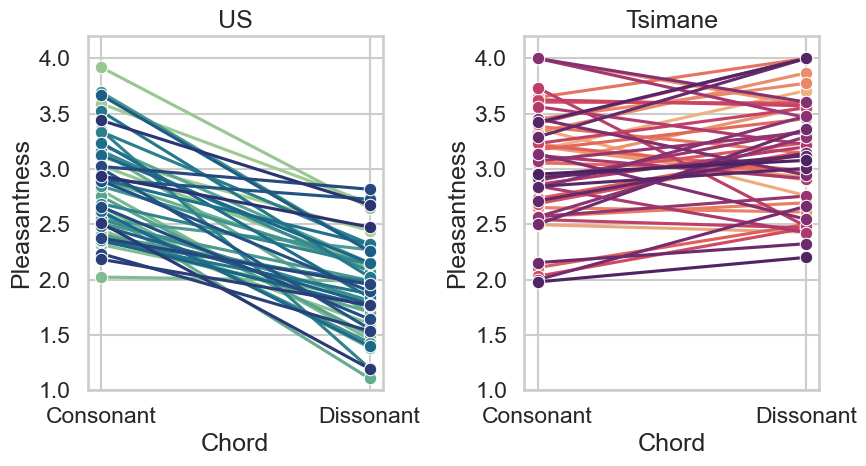

In [5]:
# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(9,5))
sns.lineplot(data=df.loc[df['Group']=='US'], ax=ax[0], x='Chord', y='Pleasantness',
             hue='Subject', marker='o', palette='crest')
ax[0].set_title('US')
ax[0].set_ylim([1, 4.2])
ax[0].get_legend().set_visible(False)
#ax[0].legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.lineplot(data=df.loc[df['Group']=='Tsimane'], ax=ax[1], x='Chord', y='Pleasantness', hue='Subject', marker='o', palette='flare')
ax[1].set_title('Tsimane')
ax[1].set_ylim([1, 4.2])
ax[1].get_legend().set_visible(False)
#ax[1].legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

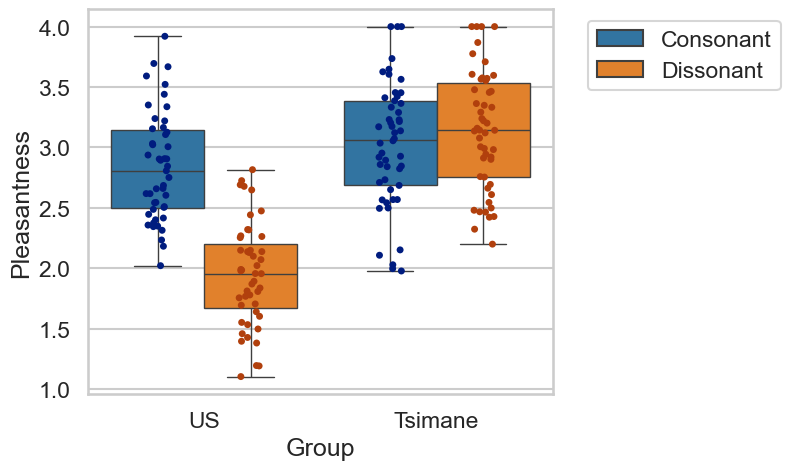

In [6]:
# Overlay both conditions, using a boxplot and strip plot
plt.figure(figsize=(6,5))
boxplot = sns.boxplot(data=df, x='Group', hue='Chord', y='Pleasantness')
handles, labels = boxplot.get_legend_handles_labels()
sns.stripplot(data=df, x='Group', hue='Chord', y='Pleasantness', dodge=True, palette='dark')
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 500x400 with 0 Axes>

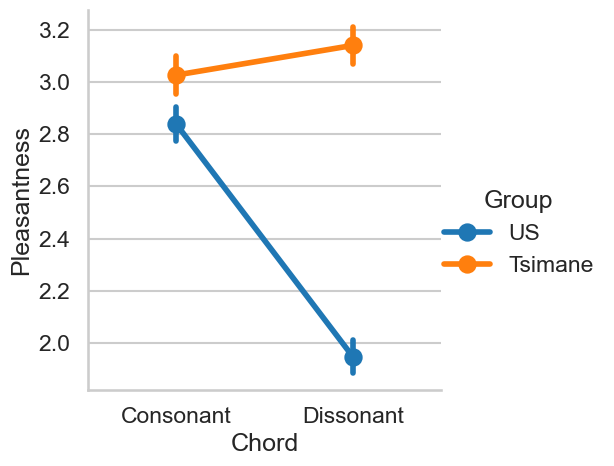

In [7]:
plt.figure(figsize=(5,4))
sns.catplot(data=df, x='Chord', y='Pleasantness', hue='Group', kind='point', errorbar='se')
plt.show()

In [9]:
# Run the repeated-measures ANOVA
aov = pg.mixed_anova(dv='Pleasantness', between='Group', within='Chord', subject='Subject',
                      data=df, effsize="ng2")
# Display the overall results
print(aov)

        Source         SS  DF1  DF2         MS           F         p-unc  \
0        Group  22.980648    1   95  22.980648   66.479977  1.427910e-12   
1        Chord   6.740990    1   95   6.740990   69.086204  6.603390e-13   
2  Interaction  12.201265    1   95  12.201265  125.046770  5.055065e-19   

        ng2  eps  
0  0.353062  NaN  
1  0.137994  1.0  
2  0.224659  NaN  


In [13]:
# mixed_anova does not display the error. Calculate this effect manually
SS_total = sum(np.power(df['Pleasantness'] - df['Pleasantness'].mean(),2))
print(f'Total SS = {SS_total}')
sbj_mean = df[['Subject','Pleasantness']].groupby('Subject').mean()
SS_sbj = sum(np.power(sbj_mean['Pleasantness'] - df['Pleasantness'].mean(),2)) * n_chord
print(f'Between-subject SS = {SS_sbj}')
print(f'Within-subject SS = {SS_total - SS_sbj}')

# Calculate within-subject and between-subject errors
SSws_err = SS_total - SS_sbj - aov['SS'][1] - aov['SS'][2]
SSbs_err = SS_sbj - aov['SS'][0]
print(f"Within-subject error SS = {SSws_err}")
print(f"Between-subject error SS = {SSbs_err}")

# Re-calculate the F-statistics, make sure they match the expected values
F_group = aov['SS'][0]/(SSbs_err/aov['DF2'][0])
F_chord = aov['SS'][1]/(SSws_err/aov['DF2'][1])
print(f'Expected F_group = {F_group}')
print(f'Expected F_chord = {F_chord}')


Total SS = 84.03178080148672
Between-subject SS = 55.820032803264816
Within-subject SS = 28.211747998221902
Within-subject error SS = 9.26949291013197
Between-subject error SS = 32.839384963279954
Expected F_group = 66.47997662683724
Expected F_chord = 69.08620429326584


### Test for sphericity

In [11]:
# Display the result of Mauchly's test for sphericity
spher, W, chi2, dof, pval = pg.sphericity(data=df, dv='Response time', within='Chord', subject='Subject')
print(f'Sphericity: W = {W:.3f}, dof = {dof}, p = {pval:.3f}')

Sphericity: W = nan, dof = 1, p = 1.000


### Multiple comparisons

In [23]:
# Calculate expected marginal means
# Pairwise Comparisons
posthocs = pg.pairwise_tests(dv='Pleasantness', between='Group', within='Chord', subject='Subject', data=df, 
                             padjust='bonf', within_first=False)
print(posthocs)

        Contrast    Group          A          B Paired Parametric          T  \
0          Group        -    Tsimane         US  False       True   8.200039   
1          Chord        -  Consonant  Dissonant   True       True   5.490018   
2  Group * Chord  Tsimane  Consonant  Dissonant   True       True  -1.832217   
3  Group * Chord       US  Consonant  Dissonant   True       True  13.689517   

         dof alternative         p-unc        p-corr p-adjust       BF10  \
0  93.641865   two-sided  1.240614e-12           NaN      NaN  5.213e+09   
1  96.000000   two-sided  3.276596e-07           NaN      NaN  4.005e+04   
2  49.000000   two-sided  7.300010e-02  1.460002e-01     bonf      0.722   
3  46.000000   two-sided  7.774254e-18  1.554851e-17     bonf  7.096e+14   

     hedges  
0  1.643410  
1  0.585296  
2 -0.224728  
3  2.024102  
